In [123]:
import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

from graph_nets import graphs
import networkx as nx

In [29]:
data_dir = 'tmp_datasets/'

feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'timestep': tf.io.FixedLenFeature([], tf.int64),
                        'parameter_vector': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string)}


In [26]:
records_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([data_dir + filename for filename in os.listdir(data_dir)]))


In [38]:
def _parse_record(x):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

parsed_records_dataset = records_dataset.map(_parse_record)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'timestep': x['timestep'],
                'parameter_vector': x['parameter_vector'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32)}
    return output

parsed_tensors_dataset = parsed_records_dataset.map(_parse_tensor)
parsed_tensors_dataset = parsed_tensors_dataset.batch(4)

In [85]:
interaction_radius = 15.0
L = 200
def preprocess_data(databatch):
    
    # node features xpos, ypos, xvel, yvel
    # edge features distance, rel angle to receiver
    X = databatch['pos']
    V = databatch['vel']
    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*L, dx-L, dx)
    dx = tf.where(dx<-0.5*L, dx+L, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*L, dy-L, dy)
    dy = tf.where(dy<-0.5*L, dy+L, dy)



    A = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - A

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    senders = sender_recv_list[:,1] + sender_recv_list[:,0]*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = sender_recv_list[:,2] + sender_recv_list[:,0]*tf.shape(adj_matrix,out_type=tf.int64)[-1]


    edge_distance = tf.expand_dims(tf.gather_nd(dist,sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # relative to sender heading
    edge_y_distance =  tf.expand_dims( tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # relative to sender heading


    edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)

    node_positions = tf.reshape(X,(-1,2))
    node_velocities = tf.reshape(V,(-1,2))

    nodes = tf.concat([node_positions,node_velocities],axis=-1)

    gn = graphs.GraphsTuple(nodes=nodes,edges=edges,globals=None,receivers=receivers,senders=senders,n_node=n_node,n_edge=n_edge)
    
    return gn

In [86]:
for d in tqdm(parsed_tensors_dataset):
    print(d['pos'].shape)
    #preprocess_data(d)
    X = d['pos']
    V = d['vel']
    break


0it [00:00, ?it/s]

(4, 100, 2)


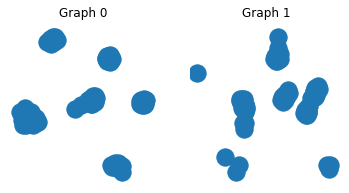

In [124]:

from graph_nets import utils_np
from graph_nets import utils_tf
graphs_nx = utils_np.graphs_tuple_to_networkxs(gn)
_, axs = plt.subplots(ncols=2, figsize=(6, 3))
for iax, (graph_nx, ax) in enumerate(zip(graphs_nx, axs)):
  nx.draw(graph_nx, ax=ax)
  ax.set_title("Graph {}".format(iax))

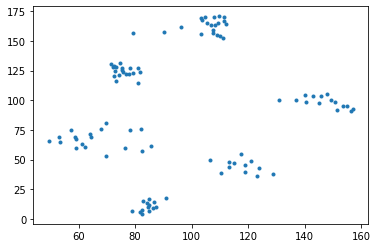

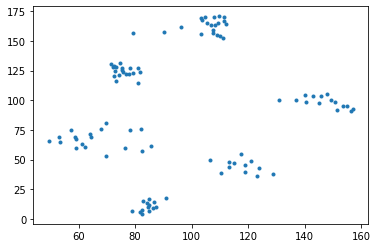

In [109]:
zzp = ZZ.numpy()[:100]

plt.plot(zzp[:,0],zzp[:,1],'.')
plt.show()

xxp = X[0].numpy()

plt.plot(xxp[:,0],xxp[:,1],'.')
plt.show()


In [94]:
1220+1370+1070+1240

4900

In [20]:
#records_dataset = tf.data.TFRecordDataset(record_file)

# Create a dictionary describing the features.



parsed_records_dataset


<MapDataset shapes: {group_id: (), parameter_vector: (None,), pos: (), timestep: (), vel: ()}, types: {group_id: tf.int64, parameter_vector: tf.float32, pos: tf.string, timestep: tf.int64, vel: tf.string}>

In [24]:
for d in tqdm(parsed_records_dataset):
    pass#print(tf.io.parse_tensor(d['pos'],out_type=tf.float32))

25000it [00:02, 9430.56it/s]
